In [459]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.max_rows=10
%matplotlib inline

In [482]:
# %load network-benchmark.py
#!/usr/bin/env python3

import configparser
import glob
import io
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


TEST_RESULT_ROOT = "/Users/esteele/tmp/wifi-test/root/wifi-test-results"
METADATA_FILENAME = "metadata.ini"
TEST_RESULT_GLOB = "*.csv"
TEST_RESULT_DIR_PATTERN = os.path.join(TEST_RESULT_ROOT, "test-run-{0}")
TEST_RESULT_METADATA_FILE = os.path.join(TEST_RESULT_DIR_PATTERN,
                                         METADATA_FILENAME)
TEST_RESULT_FILES_PATTERN = os.path.join(TEST_RESULT_DIR_PATTERN,
                                         TEST_RESULT_GLOB)


def get_test_run_results(test_run_id):
    test_result_files_glob = TEST_RESULT_FILES_PATTERN.format(test_run_id)
    result_sio = io.StringIO()
    for csv in glob.iglob(test_result_files_glob):
        with open(csv) as f:
            result_sio.write(f.read())

    # Prime for reading
    result_sio.seek(0)
    return result_sio


def get_dataframe_from_test_run(test_run_id):
    raw_run_data = get_test_run_results(test_run_id)
    summary_data = pd.read_csv(raw_run_data,
                               comment="#",
                               names=["client_id",
                                      "timestamp",
                                      "bytes_per_sec"])
    # Create a time_offset column
    summary_data["time_offset"] = \
        summary_data["timestamp"] - min(summary_data["timestamp"])
    return summary_data


def get_tick_labels(min_value, max_value, labels_count):
    return list(range(int(np.floor(min_value)),
                      int(np.ceil(max_value)),
                      int(max_value/labels_count))) + \
            [max_value]


def get_graph_title_for_run(test_run_id):
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(test_run_id))
    # Don't count the global section
    client_count = len(config.sections()) - 1
    stream_count = sum([int(config[s]["parallel_run_count"])
                        for s in config.sections()
                        if s != "global"])
    bandwidth_desc = "{0} bytes/sec".format(
        config["global"]["test_bandwidth_bps"]
    )
    title = "Run {0} against {1}{2}.\n{3} clients ({4} streams @ {5} each)" \
            .format(
                test_run_id,
                config["global"]["test_server_hostname"],
                config["global"]["extra_run_description"],
                client_count,
                stream_count,
                bandwidth_desc
            )
    return title


def get_graph_title_for_group(test_group_id):
    run_ids = get_test_run_ids_for_group_id(test_group_id)
    config = configparser.ConfigParser()
    config.read(TEST_RESULT_METADATA_FILE.format(run_ids[0]))
    # Don't count the global section
    client_count = len(config.sections()) - 1
    stream_count = sum([int(config[s]["parallel_run_count"])
                        for s in config.sections()
                        if s != "global"])
    bandwidth_desc = "{0} bytes/sec".format(
        config["global"]["test_bandwidth_bps"]
    )
    title = "Group run {0} against {1}{2} with {3} repeat runs.\n" \
            "Each with {4} clients ({5} streams @ {6} each)" \
            .format(
                test_group_id,
                config["global"]["test_server_hostname"],
                config["global"]["extra_run_description"],
                len(run_ids),
                client_count,
                stream_count,
                bandwidth_desc,
            )
    return title


def show_run_df_as_line_graph(df, title, ax):
    pivot_df = df.pivot(index="time_offset",
                        columns="client_id",
                        values="bytes_per_sec")
    ax = pivot_df.plot(figsize=(20, 10), ax=ax)
    ax.set_xlabel("Elapsed time (sec)")
    ax.set_xbound(lower=0)
    ax.set_ylabel("Throughput (bytes/sec)")
    ax.axhline(y=250000,
               color='0.75',
               linestyle="--")
    # This can sometimes cause the graph to be too large,
    #  but I can't see why as the max value is very reasonable
    #ax.annotate(" 480p bitrate",
    #            (max(df["time_offset"]), 250000))
    ax.set_title(title)


def show_multiple_run_ids_as_line_graph(run_ids):
    _, axes = plt.subplots(1, len(run_ids),
                           sharex=True,
                           sharey=True,
                           squeeze=False)

    for idx, run_id in enumerate(run_ids):
        summary_data = get_dataframe_from_test_run(run_id)
        show_run_df_as_line_graph(
            summary_data,
            get_graph_title_for_run(run_id),
            ax=axes[0][idx]
        )


def show_run_df_as_boxplot(df, title):
    labels = get_tick_labels(min(df["time_offset"]),
                             max(df["time_offset"]),
                             10)
    ax2 = df.boxplot(column="bytes_per_sec",
                     by="time_offset",
                     figsize=(10, 10)
                     )
    ax2.set_xlabel("Elapsed time (sec)")
    ax2.grid()
    ax2.set_xticks(labels)
    ax2.set_xticklabels(labels)
    ax2.set_ylabel("Throughput (bytes/sec)")
    ax2.axhline(y=250000, color='0.75', linestyle="--")
    ax2.annotate("       480p bitrate", (max(df["time_offset"]), 250000))
    ax2.set_title(title)

# memoize
def get_test_run_ids_for_group_id(test_group_id):
    matching_run_ids = []
    config = configparser.ConfigParser()
    all_metadata_files = glob.glob(
        os.path.join(TEST_RESULT_ROOT, "*", METADATA_FILENAME)
    )
    for metadata_file in all_metadata_files:
        config.read(metadata_file)
        if config.get("global", "test_group_id") == test_group_id:
            matching_run_ids.append(config.get("global", "test_run_id"))

    return matching_run_ids


def show_group_as_boxplot(test_group_id):
    run_ids = get_test_run_ids_for_group_id(test_group_id)
    group_df = pd.concat([get_dataframe_from_test_run(r) for r in run_ids])
    show_run_df_as_boxplot(group_df, get_graph_title_for_group(test_group_id))


In [483]:
# Above here, metadata is incorrect/absent
run_id = 123456789  # 3 clients, 4 total streams @250KBps (rpi3)
run_id = 99991      # 4 clients, 4 total sterams @250KBps (rpi3)
run_id = 99992      # 4 clients, 8 total sterams @250KBps (rpi3)
run_id = 99993      # 4 clients, 12 total sterams @250KBps (rpi3)
#run_id = 99994      # 4 clients, 16 total sterams @250KBps (rpi3)
#run_id = 99995      # 4 clients, 20 total sterams @250KBps (rpi3)
#run_id = 99996      # 4 clients, 24 total sterams @250KBps (rpi3)
#run_id = 99997      # 4 clients, 28 total sterams @250KBps (rpi3)
#run_id = 911726247  # 6 clients, 12 total steams (rpi3)
run_id = 1078739015 # 2 clients, 12 total streams (rpi3)
group_id = "A2"  # 6 clients, 12 total streams
group_id = "A3"  # 4 clients, 12 total streams
group_id = "A6"  # 2 clients, 12 total streams
#summary_data = get_dataframe_from_test_run(run_id)
#show_multiple_run_ids_as_line_graph([1078739015, 99993, 911726247])
#show_multiple_run_ids_as_line_graph(get_test_run_ids_for_group_id(group_id))

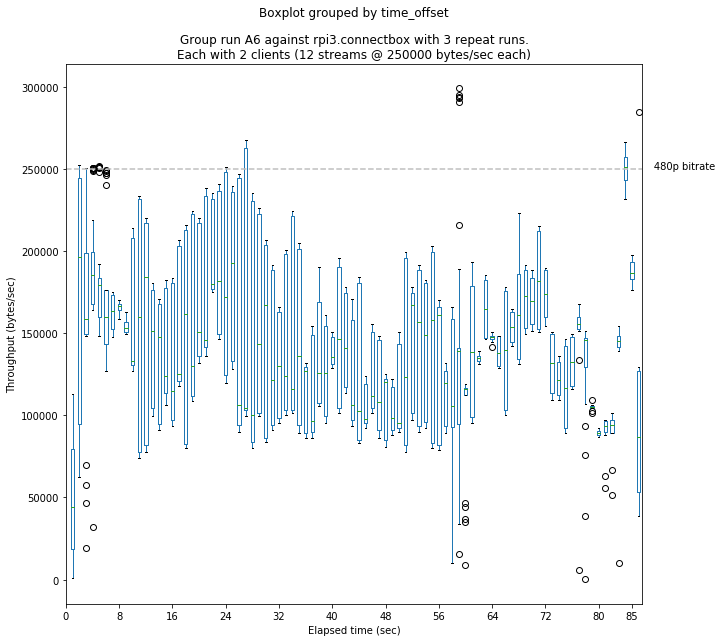

In [484]:
show_group_as_boxplot(group_id)